In [1]:
!pip install albumentations
!pip install transformers
!pip install craft_text_detector
!pip3 install opencv-python-headless==4.5.3.56

  Using cached albumentations-1.3.0-py3-none-any.whl (123 kB)
  Using cached qudida-0.0.4-py3-none-any.whl (3.5 kB)
  Using cached opencv_python_headless-4.7.0.68-cp37-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (49.2 MB)
  Using cached transformers-4.26.0-py3-none-any.whl (6.3 MB)
  Using cached huggingface_hub-0.12.0-py3-none-any.whl (190 kB)
  Using cached regex-2022.10.31-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (769 kB)
  Using cached tokenizers-0.13.2-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (7.6 MB)
  Using cached craft_text_detector-0.4.3-py3-none-any.whl (18 kB)
  Using cached opencv_python-4.5.4.60-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (60.3 MB)
  Using cached opencv_python_headless-4.5.3.56-cp39-cp39-manylinux2014_x86_64.whl (37.1 MB)
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.7.0.68
    Uninstalling opencv-python-headless-4.7.0.68:
      Successfully unin

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
from torchvision.io import read_image
from torchvision.utils import draw_bounding_boxes
import cv2
import cv2 as cv
import os
import pathlib
import sys
from pathlib import Path
import albumentations as A
from albumentations.pytorch import ToTensorV2
from tqdm import tqdm
import seaborn as sns

CPU times: user 6.61 s, sys: 309 ms, total: 6.92 s
Wall time: 5.65 s


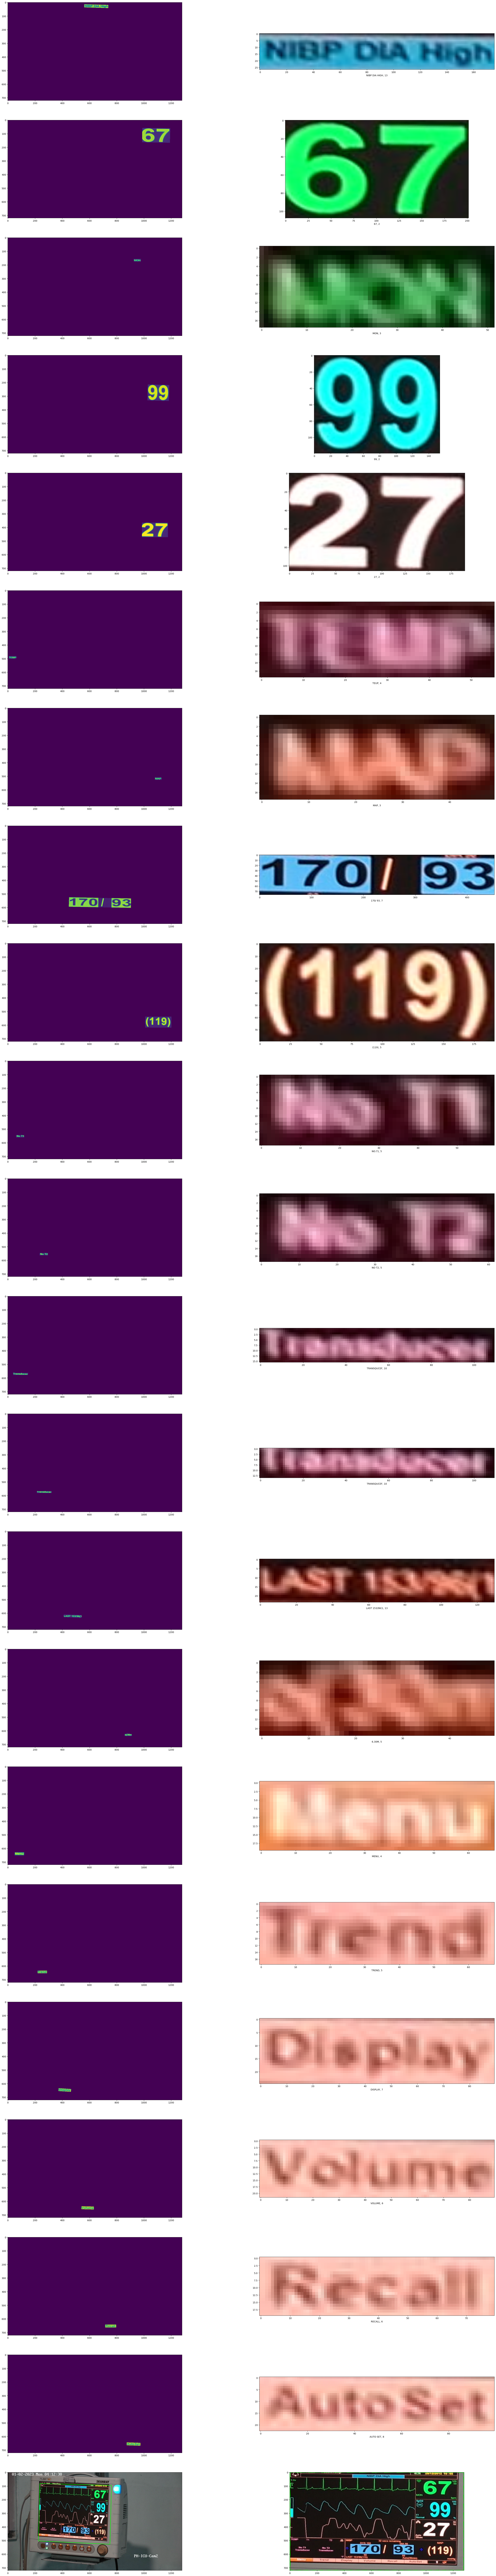

In [31]:
%%time

import unet_pred
import correct_perspective
import craft_detector
import detector
import classifier
import trocr
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np


img_idx = 2569
vitalnumber = 1

TEST_IMG_DIR = "../Step-1/Unlabelled Dataset"
imlis = os.listdir(TEST_IMG_DIR)
imloc = f"{TEST_IMG_DIR}/{imlis[img_idx]}"

data = cv2.imread(imloc)
mask = unet_pred.maskPred(imloc)

monitor =  correct_perspective.correctPerspective(data, mask)

imset = classifier.classifier(data)
imset = 2

# vitlocs = np.load("vitloc.npy", allow_pickle = True)

bounding_boxes = craft_detector.get_boxes(monitor)
bounding_boxes = list(np.expand_dims(np.round(np.array(bounding_boxes)).astype(np.int32), 2))

fig, ax = plt.subplots(len(bounding_boxes) + 1, 2, figsize = (40, 200))

croplis = []
texlis = []

for idx in range(len(bounding_boxes)):
    img = cv2.cvtColor(monitor, cv2.COLOR_BGR2GRAY)
    mask = np.zeros_like(img) # Create mask where white is what we want, black otherwise
    cv2.drawContours(mask, bounding_boxes, idx, 255, -1) # Draw filled contour in mask
    out = np.zeros_like(img) # Extract out the object and place into output image
    out[mask == 255] = img[mask == 255]
    
    
    ax[idx][0].imshow(out)
    
    text, crop = trocr.trOCR(monitor, bounding_boxes[idx])
    
    ax[idx][1].imshow(crop)
    ax[idx][1].set_xlabel(f"{text}, {len(text)}")
    
    croplis.append(crop)
    texlis.append(text)
    
ax[-1][0].imshow(data)
ax[-1][1].imshow(monitor)

In [32]:
def HRRule(crop):
    pass

In [33]:
def BPRule(crop, text):
    sbp = 0
    dbp = 0
    if('/' in text):
        pos = text.rfind('/')
        sbp = text[pos-3:pos]
        dbp = text[pos+1:pos+4]
        return [sbp, dbp]
    else:
        return "Not Found"

bpretlis = []
for crp, tx in zip(croplis, texlis):
    bpretlis.append(BPRule(crp, tx))
    
bpretlis

['Not Found',
 'Not Found',
 'Not Found',
 'Not Found',
 'Not Found',
 'Not Found',
 'Not Found',
 ['170', ' 93'],
 'Not Found',
 'Not Found',
 'Not Found',
 'Not Found',
 'Not Found',
 ['153', '96('],
 'Not Found',
 'Not Found',
 'Not Found',
 'Not Found',
 'Not Found',
 'Not Found',
 'Not Found']

In [34]:
def find(s, ch):
    return [i for i, ltr in enumerate(s) if ltr == ch]
def MAPRule(crop, text):
    st = find(text, '(')
    en = find(text, ')')
    if(len(st) > 0 and len(en) > 0):
        return text[st[0]+1:en[0]]
    else:
        return "Not Found"
mapretlis = []
for crp, tx in zip(croplis, texlis):
    mapretlis.append(MAPRule(crp, tx))
    
mapretlis

['Not Found',
 'Not Found',
 'Not Found',
 'Not Found',
 'Not Found',
 'Not Found',
 'Not Found',
 'Not Found',
 '119',
 'Not Found',
 'Not Found',
 'Not Found',
 'Not Found',
 'Not Found',
 'Not Found',
 'Not Found',
 'Not Found',
 'Not Found',
 'Not Found',
 'Not Found',
 'Not Found']

In [35]:
def SPO2Rule(crop, text):
    # if(len(text) > )
    pass

In [36]:
def RRRule(crop):
    pass

In [37]:
def HRGraphRule(crop, text):
    freqlis = [0 for i in range(26)]
    for ch in text:
        if(ord(ch) >= 65 and ord(ch) <= 90):
            freqlis[ord(ch) - 65] += 1
    for fr in freqlis:
        if (fr >= 5):
            return crop
    return "Not Found"

hrGraphretlis = []
for crp, tx in zip(croplis, texlis):
    hrGraphretlis.append(HRGraphRule(crp, tx))
    
for i in hrGraphretlis:
    if(isinstance(i, np.ndarray)):
        plt.imshow(i)